In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
data = []

In [3]:
folder_path = './pre_dataset/files'
# Duyệt qua từng folder trong folder_path
for folder in os.listdir(folder_path):
    file_path = folder_path + '/' + folder + '/measurements.json'
    # Đọc file json
    with open(file_path) as f:
        data.append(json.load(f))

In [4]:
converted_data = {}
for item in data:
    for key, value in item.items():
        if key not in converted_data:
            converted_data[key] = []
        converted_data[key].append(value)

In [5]:
for key, values in converted_data.items():
    # Check if value contains "_tbr" and remove it
    converted_data[key] = [value.replace('_tbr', '') for value in values]

In [6]:
# Tạo DataFrame từ dữ liệu
df = pd.DataFrame(converted_data)

In [7]:
df = df.drop(columns=['race', 'profession', 'age', 'gender'])
# df['gender'] = df['gender'].map({'male': 1, 'female': 0})

In [8]:
# convert height and weight to float
df['height'] = df['height'].map(lambda x: float(x.replace('cm', '')))
df['weight'] = df['weight'].map(lambda x: float(x.replace('kg', '')))

In [9]:
# calculate bmi using height and weight, then drop height and weight columns
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df = df.drop(columns=['height', 'weight'])
df.astype(float)
df.head()

,arm_circumference_cm,arm_length_cm,back_build_cm,calf_circumference_cm,chest_circumference_cm,crotch_height_cm,front_build_cm,hips_circumference_cm,leg_length_cm,neck_circumference_cm,...,neck_waist_length_back_cm,neck_waist_length_front_cm,pelvis_circumference_cm,shoulder_length_cm,shoulder_width_cm,thigh_circumference_cm,under_chest_circumference_cm,upper_arm_length_cm,waist_circumference_cm,bmi
0,32.0,65.0,38.0,33.0,93.0,79.0,41.0,86.0,108.0,37.0,...,50.0,49.0,92.0,17.0,42.0,49.0,84.0,29.0,84.0,23.661439
1,33.0,64.0,39.0,42.0,110.0,79.0,48.0,50.0,110.0,43.0,...,50.0,54.0,111.0,15.0,39.0,61.0,102.0,31.0,99.0,27.700831
2,31.0,63.0,45.0,34.0,101.0,80.0,39.0,91.0,96.0,40.0,...,53.0,53.0,100.0,21.0,45.0,54.0,99.0,29.0,86.0,27.548209
3,24.0,55.0,33.0,34.0,79.0,77.0,31.0,70.0,95.0,33.0,...,41.0,44.0,88.0,14.0,40.0,49.0,71.0,29.0,68.0,19.382145
4,25.0,55.0,32.0,34.0,86.0,68.0,27.0,84.0,88.0,35.0,...,41.0,42.0,88.0,13.0,15.0,55.0,75.0,28.0,65.0,19.948060


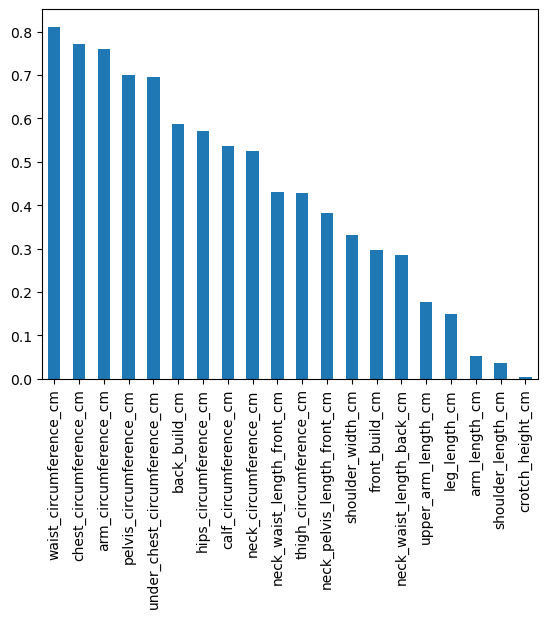

In [10]:
# plot correlation between bmi and others, order by descending
correlation = df.corr()['bmi'].abs().sort_values(ascending=False)
correlation.drop('bmi', inplace=True)
correlation.plot(kind='bar')
plt.show()

In [11]:
# features column that have correlation with bmi >= 0.
features = correlation[correlation > 0.7].index
X = df[features]
y = df['bmi']

In [12]:
# predict bmi using Random Forest, XGBoost and Gradient Boosting
# then evaluate the models using mean squared error, mean absolute error and R^2 score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# object to store the results for each model
mses = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
maes = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
r2s = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
best_params = {'Gradient Boosting': None, 'XGBoost': None, 'Random Forest': None}
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

In [14]:
# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Gradient Boosting
Mean Squared Error: 5.168813376140671
Mean Absolute Error: 2.061449130468039
R^2 Score: 0.6451160060741736


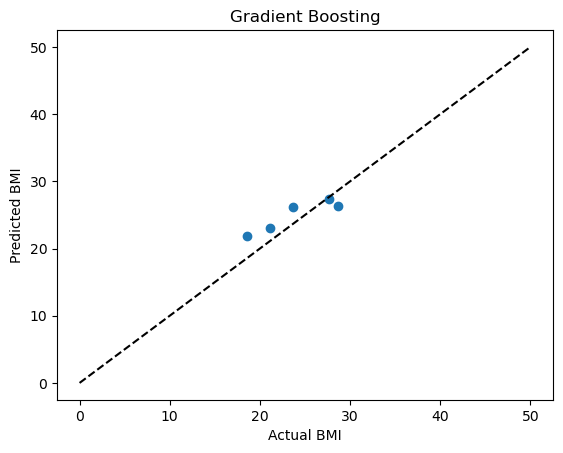

In [15]:
# Gradient Boosting, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        for learning_rate in [0.01, 0.1, 0.3]:
            model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
            scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
            # save scores to array
            mses['Gradient Boosting'].append(-scores['test_neg_mean_squared_error'].mean())
            maes['Gradient Boosting'].append(-scores['test_neg_mean_absolute_error'].mean())
            r2s['Gradient Boosting'].append(scores['test_r2'].mean())
            if scores['test_r2'].mean() > best_score:
                best_score = scores['test_r2'].mean()
                best_model = model
                best_params['Gradient Boosting'] = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

# fit the best model and predict the test
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Gradient Boosting')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# plot the actual and predicted bmi
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Gradient Boosting')
plt.show()

XGBoost
Mean Squared Error: 2.398836461944604
Mean Absolute Error: 1.4556331424110958
R^2 Score: 0.8352990130540494


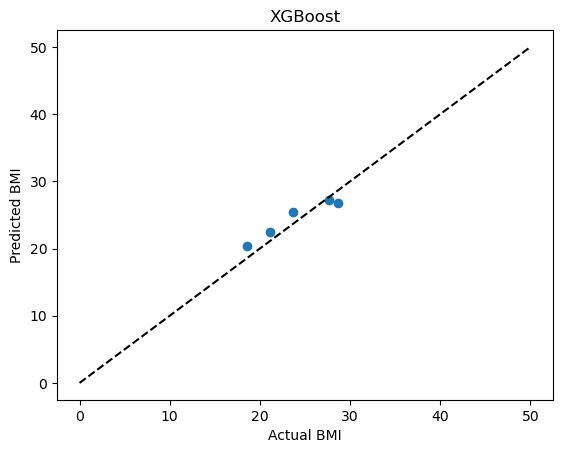

In [16]:
# XGBoost, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        for learning_rate in [0.01, 0.1, 0.3]:
            model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
            scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
            # save scores to array
            mses['XGBoost'].append(-scores['test_neg_mean_squared_error'].mean())
            maes['XGBoost'].append(-scores['test_neg_mean_absolute_error'].mean())
            r2s['XGBoost'].append(scores['test_r2'].mean())
            if scores['test_r2'].mean() > best_score:
                best_score = scores['test_r2'].mean()
                best_model = model
                best_params['XGBoost'] = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

# fit the best model and predict the test
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'XGBoost')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# plot the actual and predicted bmi
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('XGBoost')
plt.show()

Random Forest
Mean Squared Error: 3.646348447672787
Mean Absolute Error: 1.6675510218299963
R^2 Score: 0.7496464650225867


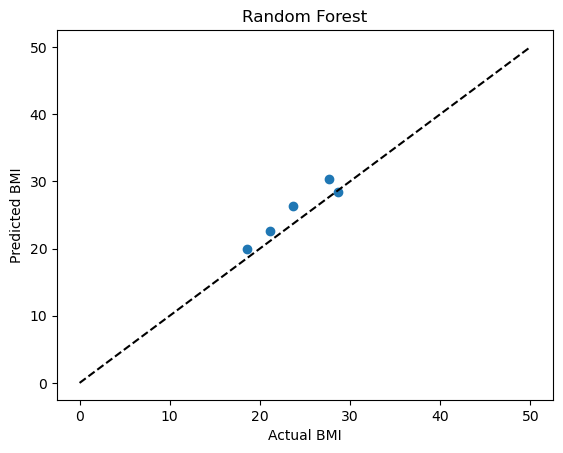

In [17]:
# Random Forest, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
        # save scores to array
        mses['Random Forest'].append(-scores['test_neg_mean_squared_error'].mean())
        maes['Random Forest'].append(-scores['test_neg_mean_absolute_error'].mean())
        r2s['Random Forest'].append(scores['test_r2'].mean())
        if scores['test_r2'].mean() > best_score:
            best_score = scores['test_r2'].mean()
            best_model = model
            best_params['Random Forest'] = {'n_estimators': n_estimators, 'max_depth': max_depth}

# fit the best model and predict the test
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Random Forest')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# plot the actual and predicted bmi
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Random Forest')
plt.show()

In [18]:
# show the best each score, best params of each measure for each model
for model in ['Gradient Boosting', 'XGBoost', 'Random Forest']:
    print(f'{model}')
    print(f'Best Mean Squared Error: {min(mses[model])}')
    print(f'Best Mean Absolute Error: {min(maes[model])}')
    print(f'Best R^2 Score: {max(r2s[model])}')
    print(f'Best Params: {best_params[model]}')
    print()

Gradient Boosting
Best Mean Squared Error: 23.031735351965672
Best Mean Absolute Error: 3.485836001313536
Best R^2 Score: 0.09770808529423033
Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}

XGBoost
Best Mean Squared Error: 17.58820991451855
Best Mean Absolute Error: 2.723588038822378
Best R^2 Score: 0.37305384806764375
Best Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}

Random Forest
Best Mean Squared Error: 20.058719564769586
Best Mean Absolute Error: 3.0139170427335813
Best R^2 Score: 0.17582122193436406
Best Params: {'n_estimators': 100, 'max_depth': 4}



In [19]:
# show them in dataframe for comparison, with the index is models
pd.options.display.float_format = '{:,.4f}'.format
df = pd.DataFrame({'Mean Squared Error': [min(mses['Random Forest']), min(mses['Gradient Boosting']), min(mses['XGBoost'])],
                   'Mean Absolute Error': [min(maes['Random Forest']), min(maes['Gradient Boosting']), min(maes['XGBoost'])],
                   'R^2': [max(r2s['Random Forest']), max(r2s['Gradient Boosting']), max(r2s['XGBoost'])]},
                  index=['Gradient Boosting', 'XGBoost', 'Random Forest'])
df

,Mean Squared Error,Mean Absolute Error,R^2
Gradient Boosting,20.0587,3.0139,0.1758
XGBoost,23.0317,3.4858,0.0977
Random Forest,17.5882,2.7236,0.3731


In [20]:
# show the best hyperparameters for each model in dataframe for comparison
# convert so that the index is the models
df = pd.DataFrame(best_params).T
df

,n_estimators,max_depth,learning_rate
Gradient Boosting,100.0000,3.0000,0.0100
XGBoost,300.0000,3.0000,0.0100
Random Forest,100.0000,4.0000,NaN


**bodyfat.csv**

In [34]:
# load dataset
df = pd.read_csv('bodyfat.csv')
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3000,23,154.2500,67.7500,36.2000,93.1000,85.2000,94.5000,59.0000,37.3000,21.9000,32.0000,27.4000,17.1000
1,1.0853,6.1000,22,173.2500,72.2500,38.5000,93.6000,83.0000,98.7000,58.7000,37.3000,23.4000,30.5000,28.9000,18.2000
2,1.0414,25.3000,22,154.0000,66.2500,34.0000,95.8000,87.9000,99.2000,59.6000,38.9000,24.0000,28.8000,25.2000,16.6000
3,1.0751,10.4000,26,184.7500,72.2500,37.4000,101.8000,86.4000,101.2000,60.1000,37.3000,22.8000,32.4000,29.4000,18.2000
4,1.0340,28.7000,24,184.2500,71.2500,34.4000,97.3000,100.0000,101.9000,63.2000,42.2000,24.0000,32.2000,27.7000,17.7000


In [35]:
# drop Density and BodyFat
df = df.drop(['Density', 'BodyFat'], axis=1)

# swap Height and Weight columns
df['Height'], df['Weight'] = df['Weight'], df['Height']
df.head()

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,23,67.7500,154.2500,36.2000,93.1000,85.2000,94.5000,59.0000,37.3000,21.9000,32.0000,27.4000,17.1000
1,22,72.2500,173.2500,38.5000,93.6000,83.0000,98.7000,58.7000,37.3000,23.4000,30.5000,28.9000,18.2000
2,22,66.2500,154.0000,34.0000,95.8000,87.9000,99.2000,59.6000,38.9000,24.0000,28.8000,25.2000,16.6000
3,26,72.2500,184.7500,37.4000,101.8000,86.4000,101.2000,60.1000,37.3000,22.8000,32.4000,29.4000,18.2000
4,24,71.2500,184.2500,34.4000,97.3000,100.0000,101.9000,63.2000,42.2000,24.0000,32.2000,27.7000,17.7000


In [36]:
# calculate the BMI, then drop Weight and Height
df['Height'] /= 100
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df = df.drop(['Weight', 'Height'], axis=1)
df.head()

,Age,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
0,23,36.2000,93.1000,85.2000,94.5000,59.0000,37.3000,21.9000,32.0000,27.4000,17.1000,28.4747
1,22,38.5000,93.6000,83.0000,98.7000,58.7000,37.3000,23.4000,30.5000,28.9000,18.2000,24.0708
2,22,34.0000,95.8000,87.9000,99.2000,59.6000,38.9000,24.0000,28.8000,25.2000,16.6000,27.9347
3,26,37.4000,101.8000,86.4000,101.2000,60.1000,37.3000,22.8000,32.4000,29.4000,18.2000,21.1675
4,24,34.4000,97.3000,100.0000,101.9000,63.2000,42.2000,24.0000,32.2000,27.7000,17.7000,20.9879


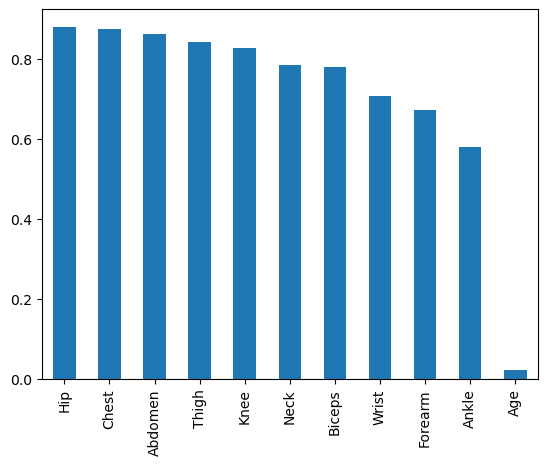

In [37]:
# show the absolute correlation between BMI and other features, order by descending
# then visualize the correlation and drop BMI in correlation
correlation = df.corr()['BMI'].abs().sort_values(ascending=False)
correlation.drop('BMI', inplace=True)
correlation.plot(kind='bar')
plt.show()

In [38]:
# get the features with correlation > 0.7
features = correlation[correlation > 0.7].index
X = df[features].astype(float)
y = df['BMI'].astype(float)

In [39]:
# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# object to store the results for each model
mses = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
maes = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
r2s = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
best_params = {'Gradient Boosting': None, 'XGBoost': None, 'Random Forest': None}
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

Gradient Boosting
Mean Squared Error: 2.3687099743841817
R^2: 0.9268980569573675
Mean Absolute Error: 1.2442879153382187


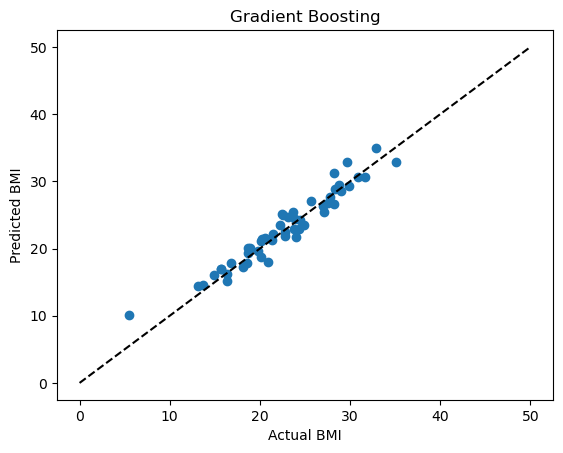

In [42]:
# Gradient Boosting, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        for learning_rate in [0.01, 0.1, 0.3]:
          model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
          scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
          # save scoring to array
          mses['Gradient Boosting'].append(-scores['test_neg_mean_squared_error'].mean())
          maes['Gradient Boosting'].append(-scores['test_neg_mean_squared_error'].mean())
          r2s['Gradient Boosting'].append(scores['test_r2'].mean())
          if scores['test_r2'].mean() > best_score:
              best_score = scores['test_r2'].mean()
              best_model = model
              best_params['Gradient Boosting'] = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

# fit the best model and predict the test
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model using mean squared error and R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Gradient Boosting')
print('Mean Squared Error:', mse)
print('R^2:', r2)
print('Mean Absolute Error:', mae)

# plot the actual and predicted BodyFat
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Gradient Boosting')
plt.show()

XGBoost
Mean Squared Error: 2.2621338937793127
R^2: 0.9301871546765214
Mean Absolute Error: 1.2140061624260425


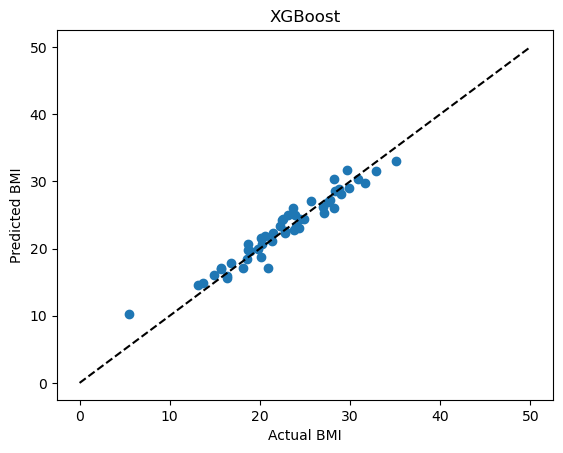

In [43]:
# XGBoost, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        for learning_rate in [0.01, 0.1, 0.3]:
            model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
            scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=False)
            # save scoring to array
            mses['XGBoost'].append(-scores['test_neg_mean_squared_error'].mean())
            maes['XGBoost'].append(-scores['test_neg_mean_absolute_error'].mean())
            r2s['XGBoost'].append(scores['test_r2'].mean())

            if scores['test_r2'].mean() > best_score:
                best_score = scores['test_r2'].mean()
                best_model = model
                best_params['XGBoost'] = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model using mean squared error and R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('XGBoost')
print('Mean Squared Error:', mse)
print('R^2:', r2)
print('Mean Absolute Error:', mae)

# plot the actual and predicted BodyFat
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('XGBoost')
plt.show()

Random Forest
Mean Squared Error: 2.625501492641064
R^2: 0.9189730854984508
Mean Absolute Error: 1.3177872850872199


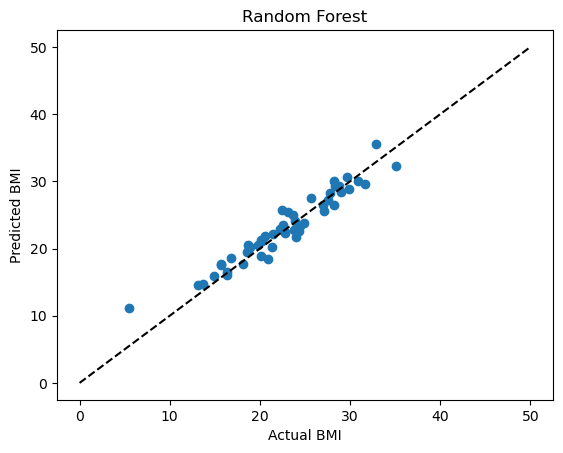

In [44]:
# Random Forest, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=False)
        # save scoring to array
        mses['Random Forest'].append(-scores['test_neg_mean_squared_error'].mean())
        maes['Random Forest'].append(-scores['test_neg_mean_absolute_error'].mean())
        r2s['Random Forest'].append(scores['test_r2'].mean())
        
        if scores['test_r2'].mean() > best_score:
            best_score = scores['test_r2'].mean()
            best_model = model
            best_params['Random Forest'] = {'n_estimators': n_estimators, 'max_depth': max_depth}

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model using mean squared error and R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest')
print('Mean Squared Error:', mse)
print('R^2:', r2)
print('Mean Absolute Error:', mae)

# plot the actual and predicted BodyFat
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Random Forest')
plt.show()

In [45]:
# show the best each score, best params of each measure for each model
for model in ['Gradient Boosting', 'XGBoost', 'Random Forest']:
    print(f'{model}')
    print(f'Best Mean Squared Error: {min(mses[model])}')
    print(f'Best Mean Absolute Error: {min(maes[model])}')
    print(f'Best R^2 Score: {max(r2s[model])}')
    print(f'Best Params: {best_params[model]}')
    print()

Gradient Boosting
Best Mean Squared Error: 3.3254288925205118
Best Mean Absolute Error: 3.3254288925205118
Best R^2 Score: 0.9354966685141222
Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

XGBoost
Best Mean Squared Error: 3.832103544083366
Best Mean Absolute Error: 1.4046695183001394
Best R^2 Score: 0.9285964360247327
Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

Random Forest
Best Mean Squared Error: 3.357315505872627
Best Mean Absolute Error: 1.3755581664036662
Best R^2 Score: 0.9340628906008653
Best Params: {'n_estimators': 300, 'max_depth': 5}



In [46]:
# show them in dataframe for comparison, with the index is models
pd.options.display.float_format = '{:,.4f}'.format
df = pd.DataFrame({'Mean Squared Error': [min(mses['Random Forest']), min(mses['Gradient Boosting']), min(mses['XGBoost'])],
                   'Mean Absolute Error': [min(maes['Random Forest']), min(maes['Gradient Boosting']), min(maes['XGBoost'])],
                   'R^2': [max(r2s['Random Forest']), max(r2s['Gradient Boosting']), max(r2s['XGBoost'])]},
                  index=['Gradient Boosting', 'XGBoost', 'Random Forest'])
df

,Mean Squared Error,Mean Absolute Error,R^2
Gradient Boosting,3.3573,1.3756,0.9341
XGBoost,3.3254,3.3254,0.9355
Random Forest,3.8321,1.4047,0.9286


In [47]:
# show the best hyperparameters for each model in dataframe for comparison
# convert so that the index is the models
df = pd.DataFrame(best_params).T
df

,n_estimators,max_depth,learning_rate
Gradient Boosting,100.0000,3.0000,0.1000
XGBoost,100.0000,3.0000,0.1000
Random Forest,300.0000,5.0000,NaN
